# Homework 1 - Ally Hayden

## Task 1

Investigate missing data in aircraft inventory dataset.

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')
pd.set_option('display.precision', 3)

df = pd.read_csv("/content/drive/MyDrive/DATA 300/T_F41SCHEDULE_B43.csv", keep_default_na=False, na_values=[""])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-59-beb8561f7e4c>:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/DATA 300/T_F41SCHEDULE_B43.csv", keep_default_na=False, na_values=[""])


<Axes: >

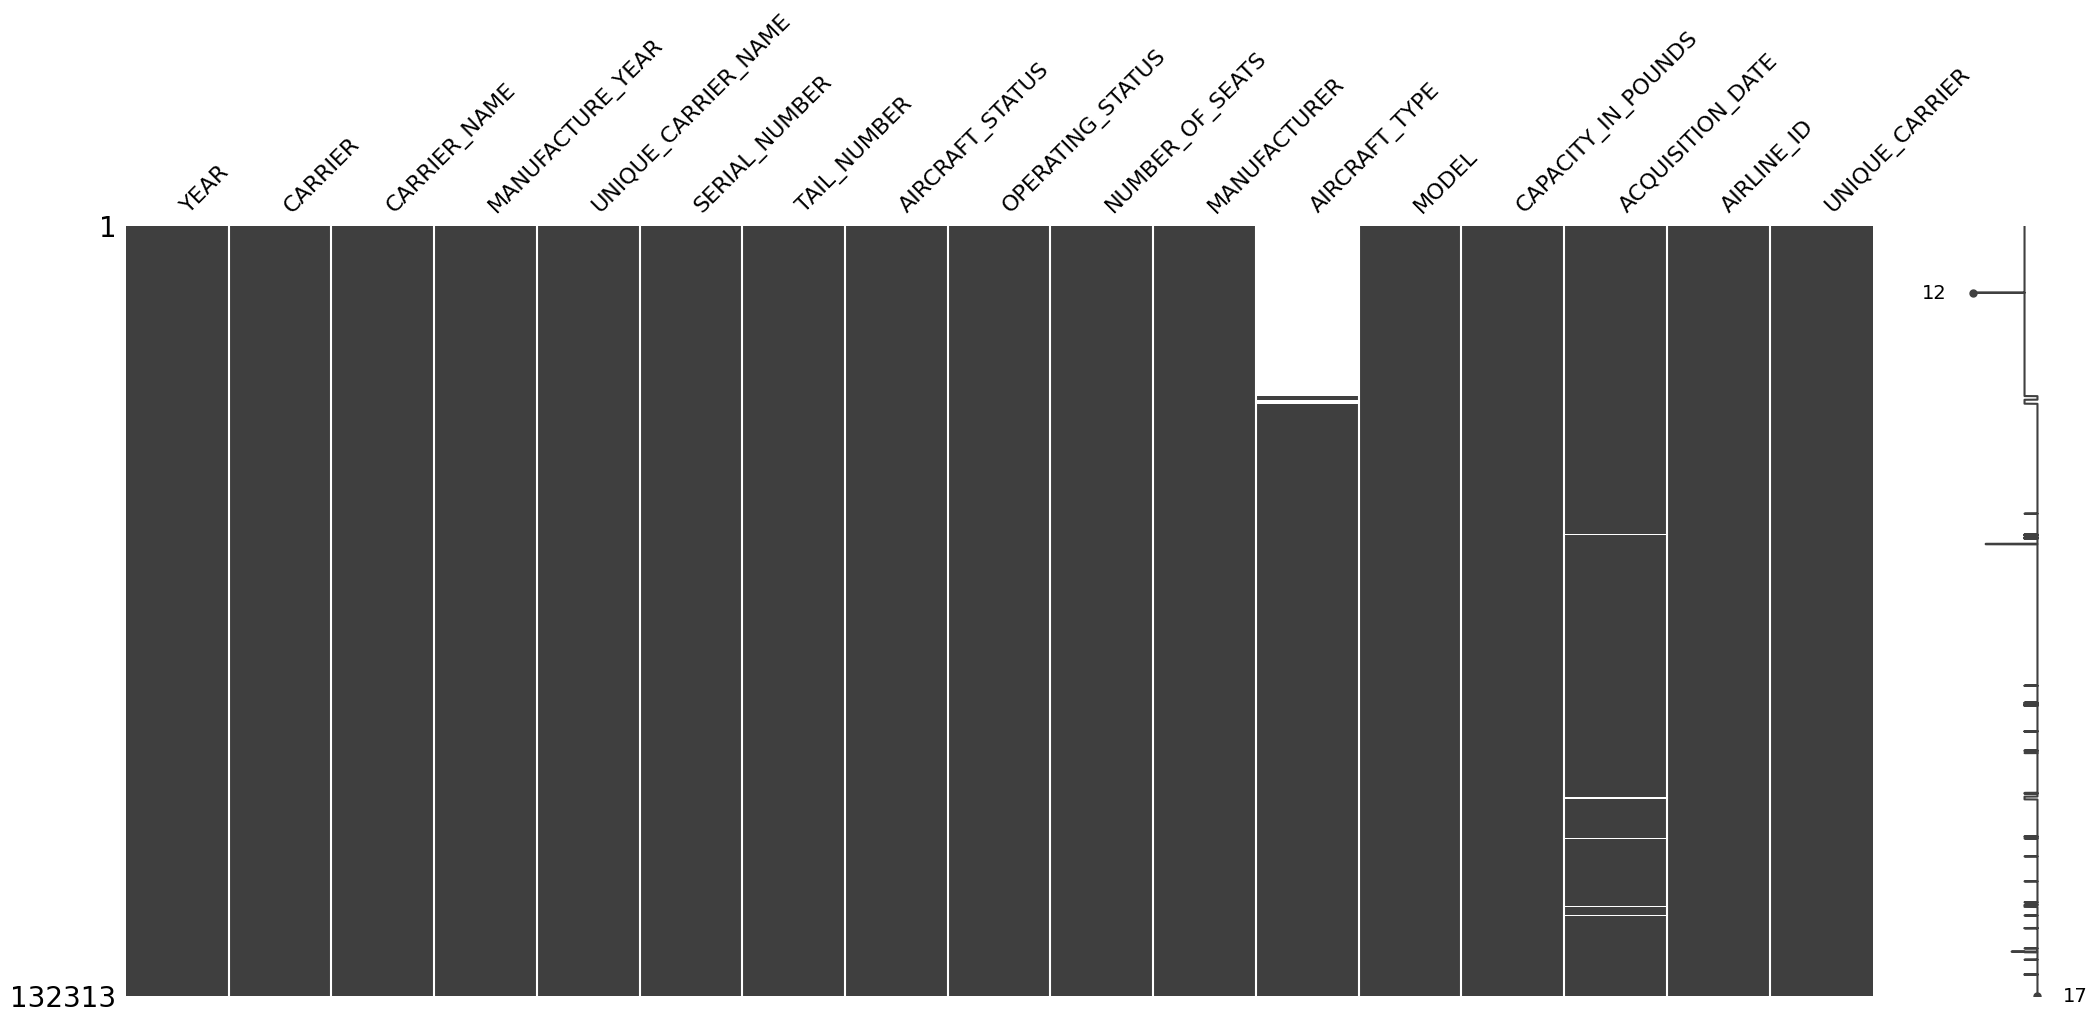

In [60]:
import missingno as msno

msno.matrix(df)

In [61]:
# columns to investigate
cols_to_check = ['CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR',
                 'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'AIRLINE_ID']

# summary
missing_summary = df[cols_to_check].isnull().sum().to_frame(name='Missing Count')
missing_summary['Missing %'] = (missing_summary['Missing Count'] / len(df)) * 100
print("Missing Data Summary:\n", missing_summary)

Missing Data Summary:
                     Missing Count  Missing %
CARRIER                         0      0.000
CARRIER_NAME                  105      0.079
MANUFACTURE_YEAR                3      0.002
NUMBER_OF_SEATS                 7      0.005
CAPACITY_IN_POUNDS            101      0.076
AIRLINE_ID                    105      0.079


CARRIER column

After changing the pd.read_csv line to only count blank cells as missing the carrier column has 0 missing values so we do not need to impute it.


CARRIER_NAME column

In [62]:
# see if carrier_name and unique_care_name are missing in the same place
missing_carrier_name = df[df['CARRIER_NAME'].isna()]
print(missing_carrier_name[['CARRIER', 'UNIQUE_CARRIER_NAME']].drop_duplicates())


      CARRIER UNIQUE_CARRIER_NAME
11465      L4                 NaN
54610      OH                 NaN


These rows have missing values in both CARRIER_NAME and UNIQUE_CARRIER_NAME. Therefore, they cannot be imputed from UNIQUE_CARRIER_NAME. I believe it is safer to leave these rows unimputed because there are so few.

AIRLINE_ID Column

In [63]:
# check how many unique AIRLINE_IDs exist
carrier_id_check = df.groupby('CARRIER')['AIRLINE_ID'].nunique().sort_values(ascending=False)
print(carrier_id_check.head(10))  # shows if some carriers always map to one ID


CARRIER
PT     2
OH     2
YX     2
0WQ    1
16     1
1BQ    1
1EQ    1
16     1
20Q    1
23Q    1
Name: AIRLINE_ID, dtype: int64


Some CARRIERs map to only one AIRLINE_ID:

0WQ, 16, 1BQ, 1EQ, 20Q, 23Q

It is safe to impute these but ONLY these.

In [64]:
# put it the carriers that map to only ONE airline_id
unique_mappings = df.groupby('CARRIER')['AIRLINE_ID'].nunique()
single_id_carriers = unique_mappings[unique_mappings == 1].index

carrier_to_id = df[df['CARRIER'].isin(single_id_carriers)].dropna(subset=['AIRLINE_ID']).drop_duplicates('CARRIER')[['CARRIER', 'AIRLINE_ID']].set_index('CARRIER')['AIRLINE_ID'].to_dict()

df['AIRLINE_ID'] = df.apply(
    lambda row: carrier_to_id[row['CARRIER']] if pd.isna(row['AIRLINE_ID']) and row['CARRIER'] in carrier_to_id else row['AIRLINE_ID'],
    axis=1
)


CAPACITY_IN_POUNDS


We can impute CAPACITY_IN_POUNDS becuase its a numeric continuous variable and the data is structured.

I chose Median becuase it is less influenced by extreme values, KNN on its own operated the same as Median but KNN with features captures inter-variable patterns.


RMSE (Median - CAPACITY_IN_POUNDS): 92646.40


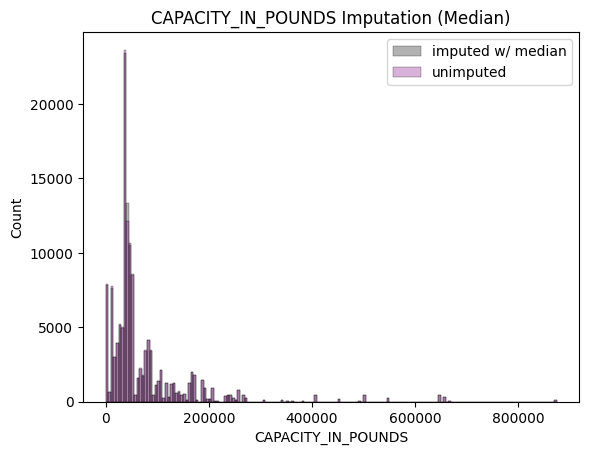

RMSE (KNN - CAPACITY_IN_POUNDS): 92646.40


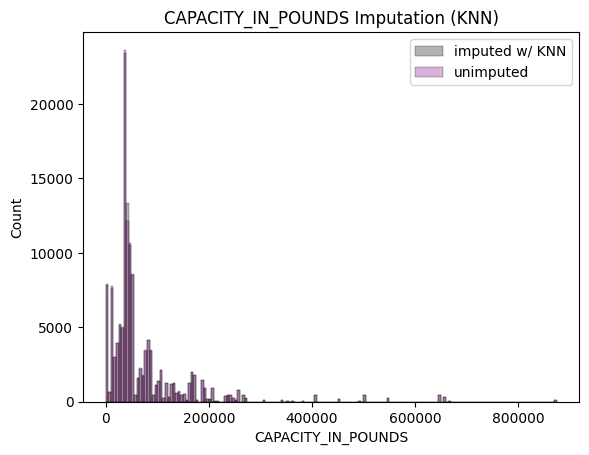

RMSE (KNN with features - CAPACITY_IN_POUNDS): 44381.46


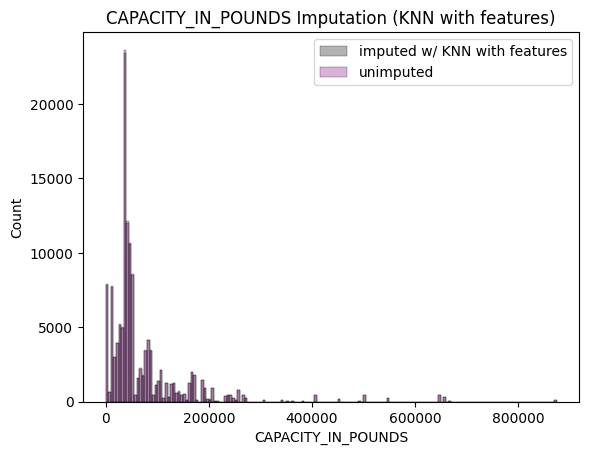

In [65]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error

# random missing
df_temp = df[['CAPACITY_IN_POUNDS']].dropna().copy()
df_temp.loc[df_temp.sample(frac=0.01, random_state=0).index, 'CAPACITY_IN_POUNDS'] = np.nan

true_vals_cap = df[['CAPACITY_IN_POUNDS']].dropna().loc[df_temp[df_temp['CAPACITY_IN_POUNDS'].isna()].index]

# Median
median_imputer_cap = SimpleImputer(strategy='median')
df_temp['CAPACITY_IN_POUNDS'] = median_imputer_cap.fit_transform(df_temp[['CAPACITY_IN_POUNDS']])

# RMSE
rmse_cap = np.sqrt(mean_squared_error(true_vals_cap, df_temp.loc[true_vals_cap.index]))
print(f"RMSE (Median - CAPACITY_IN_POUNDS): {rmse_cap:.2f}")

# Plot
fig, ax = plt.subplots(1, 1)
sns.histplot(df_temp['CAPACITY_IN_POUNDS'], binwidth=5000, alpha=0.3, color='k', label='imputed w/ median')
sns.histplot(df['CAPACITY_IN_POUNDS'], binwidth=5000, alpha=0.3, color='purple', label='unimputed')
ax.set_title('CAPACITY_IN_POUNDS Imputation (Median)')
ax.legend()
plt.show()


# KNN
knn_imputer_cap = KNNImputer(n_neighbors=5)
df_temp['CAPACITY_IN_POUNDS'] = knn_imputer_cap.fit_transform(df_temp[['CAPACITY_IN_POUNDS']])

# RMSE
rmse_cap_knn = np.sqrt(mean_squared_error(true_vals_cap, df_temp.loc[true_vals_cap.index]))
print(f"RMSE (KNN - CAPACITY_IN_POUNDS): {rmse_cap_knn:.2f}")

# Plot
fig, ax = plt.subplots(1, 1)
sns.histplot(df_temp['CAPACITY_IN_POUNDS'], binwidth=5000, alpha=0.3, color='k', label='imputed w/ KNN')
sns.histplot(df['CAPACITY_IN_POUNDS'], binwidth=5000, alpha=0.3, color='purple', label='unimputed')
ax.set_title('CAPACITY_IN_POUNDS Imputation (KNN)')
ax.legend()
plt.show()

# KNN with features
knn_df = df[['CAPACITY_IN_POUNDS', 'NUMBER_OF_SEATS', 'MANUFACTURE_YEAR']].dropna().reset_index(drop=True)

missing_idx = knn_df.sample(frac=0.01, random_state=0).index
true_vals = knn_df.loc[missing_idx, 'CAPACITY_IN_POUNDS'].copy()
knn_df.loc[missing_idx, 'CAPACITY_IN_POUNDS'] = np.nan

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed = pd.DataFrame(knn_imputer.fit_transform(knn_df), columns=knn_df.columns)

# RMSE
rmse_better = np.sqrt(mean_squared_error(true_vals, knn_imputed.loc[missing_idx, 'CAPACITY_IN_POUNDS']))
print(f"RMSE (KNN with features - CAPACITY_IN_POUNDS): {rmse_better:.2f}")

# Plot
fig, ax = plt.subplots(1, 1)
sns.histplot(knn_df['CAPACITY_IN_POUNDS'], binwidth=5000, alpha=0.3, color='k', label='imputed w/ KNN with features')
sns.histplot(df['CAPACITY_IN_POUNDS'], binwidth=5000, alpha=0.3, color='purple', label='unimputed')
ax.set_title('CAPACITY_IN_POUNDS Imputation (KNN with features)')
ax.legend()
plt.show()

MANUFACTURE_YEAR:

We can impute MANUFACTURE_YEAR because it is a numeric, discrete variable, the missing values are relatively rare and likely missing at rando, and there's a clear association with other variables like MODEL or AIRLINE_ID.

I chose to use Median because it works well when data is clustered and I chose PMM becuase it guarantees realistic values and avoids artificial midpoints.

RMSE (MANUFACTURE_YEAR): 10.16


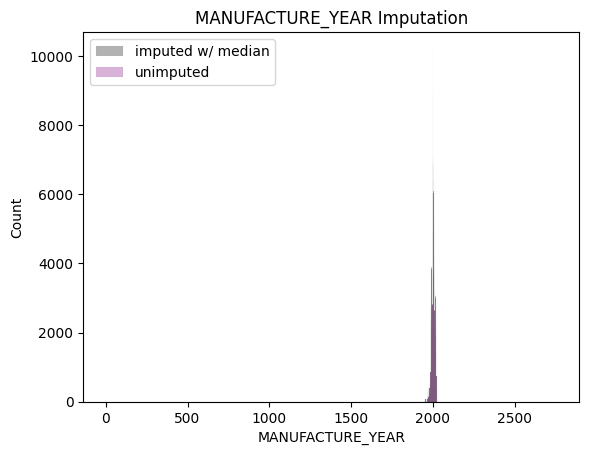

RMSE (PMM - MANUFACTURE_YEAR): 7.06


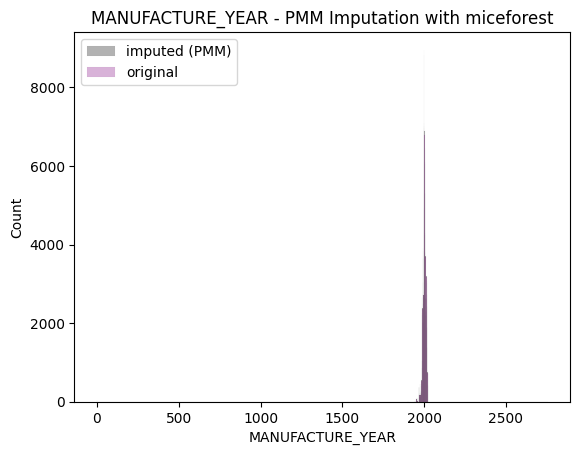

In [66]:
# random missing
df_temp = df[['MANUFACTURE_YEAR']].dropna().copy()
df_temp.loc[df_temp.sample(frac=0.01, random_state=0).index, 'MANUFACTURE_YEAR'] = np.nan

true_vals_year = df[['MANUFACTURE_YEAR']].dropna().loc[df_temp[df_temp['MANUFACTURE_YEAR'].isna()].index]

# Median
median_imputer_year = SimpleImputer(strategy='median')
df_temp['MANUFACTURE_YEAR'] = median_imputer_year.fit_transform(df_temp[['MANUFACTURE_YEAR']])

# RMSE
rmse_year = np.sqrt(mean_squared_error(true_vals_year, df_temp.loc[true_vals_year.index]))
print(f"RMSE (MANUFACTURE_YEAR): {rmse_year:.2f}")

# Plot
fig, ax = plt.subplots(1, 1)
sns.histplot(df_temp['MANUFACTURE_YEAR'], binwidth=1, alpha=0.3, color='k', label='imputed w/ median')
sns.histplot(df['MANUFACTURE_YEAR'], binwidth=1, alpha=0.3, color='purple', label='unimputed')
ax.set_title('MANUFACTURE_YEAR Imputation')
ax.legend()
plt.show()

import miceforest as mf

# PMM
df_pmm = df[['MANUFACTURE_YEAR', 'CAPACITY_IN_POUNDS', 'NUMBER_OF_SEATS']].dropna().reset_index(drop=True)

missing_idx = df_pmm.sample(frac=0.01, random_state=0).index
true_vals = df_pmm.loc[missing_idx, 'MANUFACTURE_YEAR'].copy()
df_pmm.loc[missing_idx, 'MANUFACTURE_YEAR'] = np.nan

num_datasets = 4
kernel = mf.ImputationKernel(
    data=df_pmm,
    num_datasets=num_datasets,
    save_all_iterations_data=False,
    random_state=1
)

kernel.mice(1)

df_completed = kernel.complete_data(dataset=0)

# RMSE
rmse_pmm = np.sqrt(mean_squared_error(true_vals, df_completed.loc[missing_idx, 'MANUFACTURE_YEAR']))
print(f"RMSE (PMM - MANUFACTURE_YEAR): {rmse_pmm:.2f}")

# Plot
fig, ax = plt.subplots(1, 1)
sns.histplot(df_completed['MANUFACTURE_YEAR'], binwidth=1, alpha=0.3, color='k', label='imputed (PMM)')
sns.histplot(df_pmm['MANUFACTURE_YEAR'].dropna(), binwidth=1, alpha=0.3, color='purple', label='original')
ax.set_title('MANUFACTURE_YEAR - PMM Imputation with miceforest')
ax.legend()
plt.show()



NUMBER_OF_SEATS:

We can impute NUMBER_OF_SEATS because it's a discrete, positive integer tied to the MODEL of the aircraft and there's low variation within the model.

I chose to use Median beause it's simple and most aircrafts of the same model have the same seat amount. Same as with CAPACITY_IN_POUNDS I found that KNN alone was similar to Median but KNN with features improved accuracy by taking into account multiple features.

RMSE (Median - NUMBER_OF_SEATS): 77.11


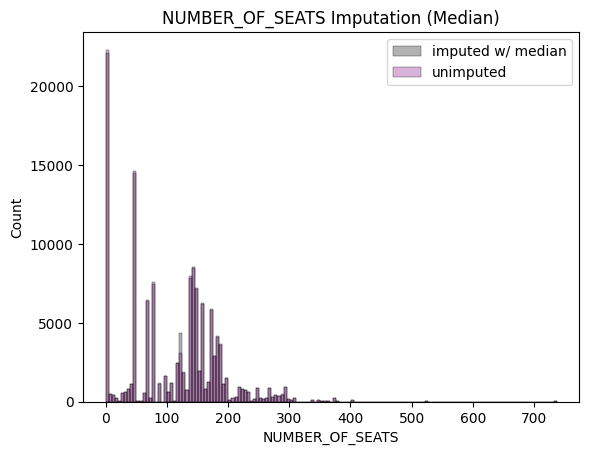

RMSE (KNN - NUMBER_OF_SEATS): 77.11


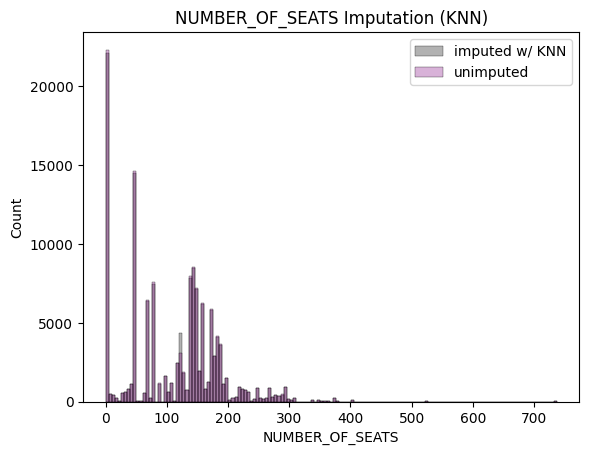

RMSE (KNN with features - NUMBER_OF_SEATS): 16.60


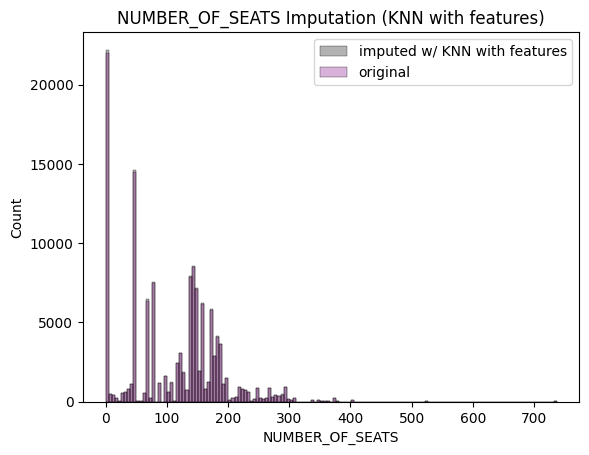

In [67]:
# random missing
df_temp = df[['NUMBER_OF_SEATS']].dropna().copy()
df_temp.loc[df_temp.sample(frac=0.01, random_state=0).index, 'NUMBER_OF_SEATS'] = np.nan

true_vals_seats = df[['NUMBER_OF_SEATS']].dropna().loc[df_temp[df_temp['NUMBER_OF_SEATS'].isna()].index]

# Median
median_imputer_seats = SimpleImputer(strategy='median')
df_temp['NUMBER_OF_SEATS'] = median_imputer_seats.fit_transform(df_temp[['NUMBER_OF_SEATS']])

# RMSE
rmse_seats = np.sqrt(mean_squared_error(true_vals_seats, df_temp.loc[true_vals_seats.index]))
print(f"RMSE (Median - NUMBER_OF_SEATS): {rmse_seats:.2f}")

# Plot
fig, ax = plt.subplots(1, 1)
sns.histplot(df_temp['NUMBER_OF_SEATS'], binwidth=5, alpha=0.3, color='k', label='imputed w/ median')
sns.histplot(df['NUMBER_OF_SEATS'], binwidth=5, alpha=0.3, color='purple', label='unimputed')
ax.set_title('NUMBER_OF_SEATS Imputation (Median)')
ax.legend()
plt.show()

# KNN
knn_imputer_seats = KNNImputer(n_neighbors=5)
df_temp['NUMBER_OF_SEATS'] = knn_imputer_seats.fit_transform(df_temp[['NUMBER_OF_SEATS']])

# RMSE
rmse_seats_knn = np.sqrt(mean_squared_error(true_vals_seats, df_temp.loc[true_vals_seats.index]))
print(f"RMSE (KNN - NUMBER_OF_SEATS): {rmse_seats_knn:.2f}")

# Plot
fig, ax = plt.subplots(1, 1)
sns.histplot(df_temp['NUMBER_OF_SEATS'], binwidth=5, alpha=0.3, color='k', label='imputed w/ KNN')
sns.histplot(df['NUMBER_OF_SEATS'], binwidth=5, alpha=0.3, color='purple', label='unimputed')
ax.set_title('NUMBER_OF_SEATS Imputation (KNN)')
ax.legend()
plt.show()

# KNN with features
knn_df = df[['NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'MANUFACTURE_YEAR']].dropna().reset_index(drop=True)

missing_idx = knn_df.sample(frac=0.01, random_state=0).index
true_vals = knn_df.loc[missing_idx, 'NUMBER_OF_SEATS'].copy()
knn_df.loc[missing_idx, 'NUMBER_OF_SEATS'] = np.nan

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed = pd.DataFrame(knn_imputer.fit_transform(knn_df), columns=knn_df.columns)

# RMSE
rmse_seats_knn_features = np.sqrt(mean_squared_error(true_vals, knn_imputed.loc[missing_idx, 'NUMBER_OF_SEATS']))
print(f"RMSE (KNN with features - NUMBER_OF_SEATS): {rmse_seats_knn_features:.2f}")

# Plot
fig, ax = plt.subplots(1, 1)
sns.histplot(knn_imputed['NUMBER_OF_SEATS'], binwidth=5, alpha=0.3, color='k', label='imputed w/ KNN with features')
sns.histplot(knn_df['NUMBER_OF_SEATS'], binwidth=5, alpha=0.3, color='purple', label='original')
ax.set_title('NUMBER_OF_SEATS Imputation (KNN with features)')
ax.legend()
plt.show()

In [68]:
# Adding numerical imputed columns to the df
df_extended = df.copy()

df_extended.loc[df_completed.index, 'MANUFACTURE_YEAR_PMM'] = df_completed['MANUFACTURE_YEAR'].round()
df_extended.loc[knn_df.index, 'NUMBER_OF_SEATS_KNN_FEATURES'] = knn_imputed['NUMBER_OF_SEATS'].round()
df_extended.loc[knn_df.index, 'CAPACITY_IN_POUNDS_KNN_FEATURES'] = knn_imputed['CAPACITY_IN_POUNDS'].round()


## Task 2

Inspect the columns MANUFACTURER, MODEL, AIRCRAFT_STATUS, and OPERATING_STATUS and decide if transformation or standardization of data are required.

MANUFACTURER column

In [69]:
# convert to upper and get rid of spaces
df_extended['MANUFACTURER_CLEAN'] = df_extended['MANUFACTURER'].str.upper().str.strip()

manufacturer_map = {
    "BOEING": "BOEING",
    "THEBOEINGCO": "BOEING",
    "BOEING COMPANY": "BOEING",
    "BOEINGCO": "BOEING",
    "AIRBUS INDUSTRIE": "AIRBUS",
    "AIRBUS": "AIRBUS",
    "BOMBARDIER INC": "BOMBARDIER",
    "EMBRAER S.A.": "EMBRAER",
    "EMBRAER": "EMBRAER",
    "GULFSTREAM AEROSPACE": "GULFSTREAM",
    "CESSNA AIRCRAFT COMPANY": "CESSNA",
    "CESSNA": "CESSNA"
}

df_extended['MANUFACTURER_STD'] = df_extended['MANUFACTURER_CLEAN'].replace(manufacturer_map)

print(df_extended['MANUFACTURER_STD'].value_counts().head(20))

MANUFACTURER_STD
BOEING                 44191
EMBRAER                15554
AIRBUS                 13440
BOMBARDIER             11834
AIRBUSINDUSTRIES        7053
BOEINGCOMPANY           6767
CESSNA                  4514
MCDONNELLDOUGLAS        4306
MCDONNELL-DOUGLAS       4159
THEBOEINGCOMPANY        3975
CANADAIR                3861
AIRBUSINDUSTRIE         2666
ATR                     1181
DOUGLAS                 1137
GE                      1110
DEHAVILLAND             1084
MCDONNELDOUGLAS          736
BOMBARDIERAEROSPACE      649
BOEINGCO.                584
GULFSTREAM               441
Name: count, dtype: int64


MODEL column

In [70]:
# convert to upper and get rid of spaces
df_extended['MODEL_CLEAN'] = df_extended['MODEL'].str.upper().str.strip()

print(df_extended['MODEL_CLEAN'].value_counts().head(30))

model_map = {
    "737-800": "BOEING 737-800",
    "737": "BOEING 737",
    "B737": "BOEING 737",
    "B737-800": "BOEING 737-800",
    "A320": "AIRBUS A320",
    "A320-200": "AIRBUS A320",
    "BOMBARDIER CRJ200": "CRJ200",
    "CRJ-200": "CRJ200",
    "EMBRAER 170": "EMBRAER E170",
    "EMB-170": "EMBRAER E170"
}

df_extended['MODEL_STD'] = df_extended['MODEL_CLEAN'].replace(model_map)

print(df_extended['MODEL_STD'].value_counts().head(10))


MODEL_CLEAN
EMB-145                 2976
B-737-7H4               2470
B737-823                2370
A320-232                2333
A321-231                2259
737-700PASSENGERONLY    2027
C-208B                  1872
B757-2                  1775
CRJ-2/4                 1761
B737-800PAX             1621
MD-80                   1610
A320-1/2                1466
ERJ-170-200LR           1379
B737-7/L                1349
757-200                 1345
CRJ200-2B19             1342
A319                    1267
B-737-8H4               1256
CRJ-200                 1148
ERJ-175                 1132
SUPER80PASSENGER        1108
MD-11                   1107
757-24APF               1039
B737-3                  1036
MD-88-PSGR              1028
C-208B/3                1017
757-232-PSGR             988
CRJ-900LR-PSGR           976
B737-823PASSENGER        956
B737-8                   951
Name: count, dtype: int64
MODEL_STD
EMB-145                 2976
B-737-7H4               2470
B737-823                

AIRCRAFT_STATUS column

In [71]:
# convert to lower and get rid of spaces
df_extended['AIRCRAFT_STATUS_CLEAN'] = df_extended['AIRCRAFT_STATUS'].str.lower().str.strip()

print(df_extended['AIRCRAFT_STATUS_CLEAN'].value_counts())

aircraft_status_map = {
    "active": "active",
    "inactive": "inactive",
    "retired": "retired",
    "destroyed": "retired",
    "decommissioned": "retired",
    "in service": "active",
    "not in service": "inactive"
}

df_extended['AIRCRAFT_STATUS_STD'] = df_extended['AIRCRAFT_STATUS_CLEAN'].replace(aircraft_status_map)

print(df_extended['AIRCRAFT_STATUS_STD'].value_counts())

AIRCRAFT_STATUS_CLEAN
o    79506
b    43551
a     9134
l      122
Name: count, dtype: int64
AIRCRAFT_STATUS_STD
o    79506
b    43551
a     9134
l      122
Name: count, dtype: int64


OPERATING_STATUS column

In [72]:
# convert to lower and get rid of spaces
df_extended['OPERATING_STATUS_CLEAN'] = df_extended['OPERATING_STATUS'].str.lower().str.strip()

print(df_extended['OPERATING_STATUS_CLEAN'].value_counts())

operating_status_map = {
    "operating": "operating",
    "not operating": "not operating",
    "inactive": "not operating",
    "active": "operating",
    "temporarily inactive": "not operating",
    "unknown": "unknown"
}

df_extended['OPERATING_STATUS_STD'] = df_extended['OPERATING_STATUS_CLEAN'].replace(operating_status_map)

print(df_extended['OPERATING_STATUS_STD'].value_counts())



OPERATING_STATUS_CLEAN
y    126648
n      5664
          1
Name: count, dtype: int64
OPERATING_STATUS_STD
y    126648
n      5664
          1
Name: count, dtype: int64


## Task 3

Remove data rows with missing values.

In [73]:
cleaned_aircraft_inventory = df_extended.dropna()
print(f"Remaining rows after dropping missing values: {len(cleaned_aircraft_inventory)}")

Remaining rows after dropping missing values: 101096


## Task 4

Transformation and derivative variables with NUMBER_OF_SEATS and CAPACITY_IN_POUNDS

NUMBER_OF_SEATS skewness before Box-Cox: 0.78


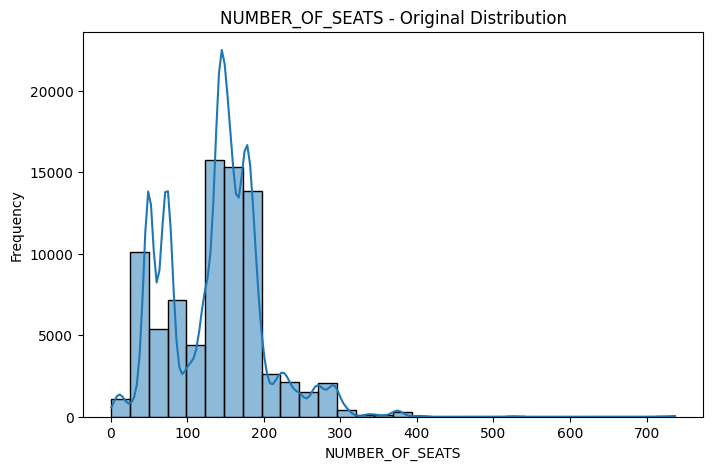

CAPACITY_IN_POUNDS skewness before Box-Cox: 4.18


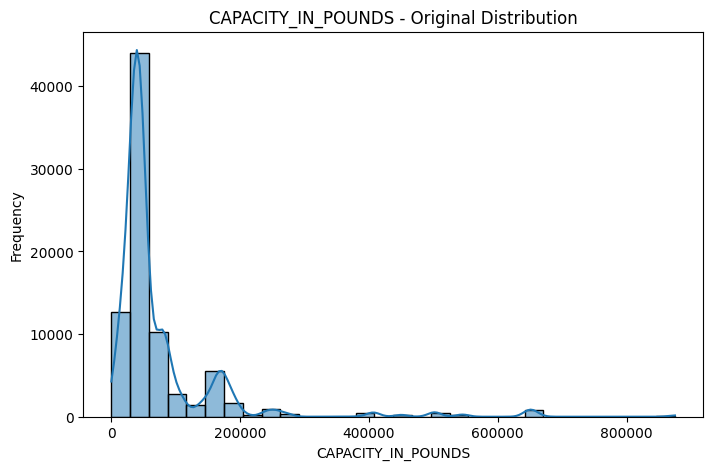

NUMBER_OF_SEATS_BOXCOX skewness after Box-Cox: 0.01


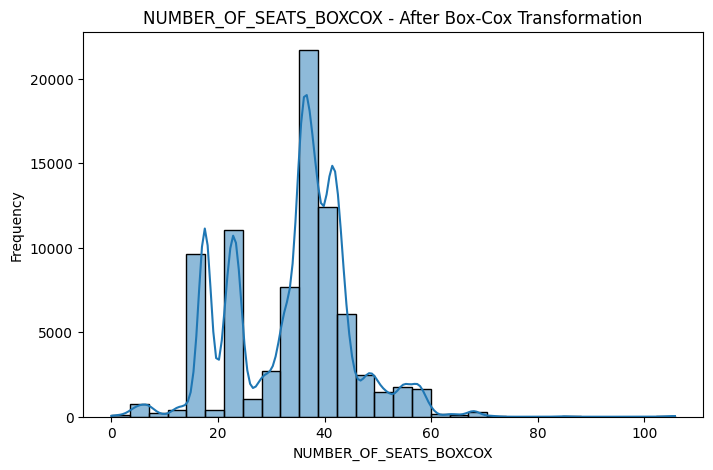

CAPACITY_IN_POUNDS_BOXCOX skewness after Box-Cox: 0.07


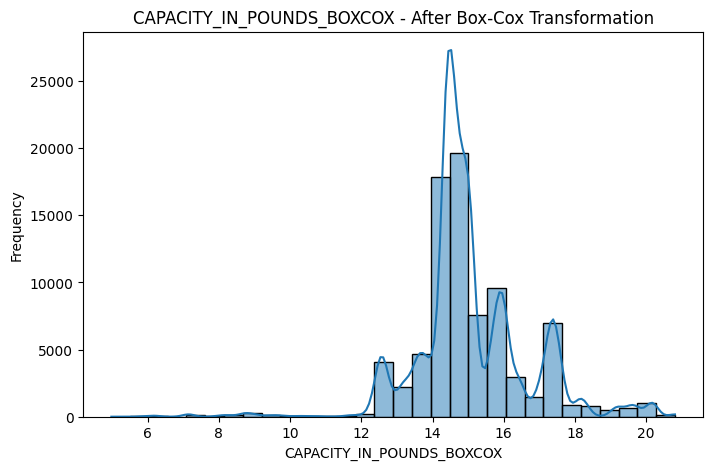

In [74]:
from scipy.stats import boxcox

filtered_data = cleaned_aircraft_inventory[(cleaned_aircraft_inventory['NUMBER_OF_SEATS'] > 0) &
                                           (cleaned_aircraft_inventory['CAPACITY_IN_POUNDS'] > 0)].copy()

# check skewness and plot original histograms
for col in ['NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS']:
    skewness = filtered_data[col].skew()
    print(f"{col} skewness before Box-Cox: {skewness:.2f}")

    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_data[col], bins=30, kde=True)
    plt.title(f'{col} - Original Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# apply Box-Cox transformation
filtered_data['NUMBER_OF_SEATS_BOXCOX'], _ = boxcox(filtered_data['NUMBER_OF_SEATS'])
filtered_data['CAPACITY_IN_POUNDS_BOXCOX'], _ = boxcox(filtered_data['CAPACITY_IN_POUNDS'])

# check skewness and plot new histograms
for col in ['NUMBER_OF_SEATS_BOXCOX', 'CAPACITY_IN_POUNDS_BOXCOX']:
    skewness = filtered_data[col].skew()
    print(f"{col} skewness after Box-Cox: {skewness:.2f}")

    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_data[col], bins=30, kde=True)
    plt.title(f'{col} - After Box-Cox Transformation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


Box-Cox Transformation Summary
✅ Before Transformation
NUMBER_OF_SEATS had a skewness of 0.78, indicating a moderately right-skewed distribution. This is common in aviation data, where small regional jets are more frequent, and larger aircraft are less common but still present.

CAPACITY_IN_POUNDS showed heavy right skew with a skewness of 4.18. This reflects extreme variation in aircraft size — from light jets to very heavy commercial or cargo planes.

🔄 After Box-Cox Transformation
NUMBER_OF_SEATS_BOXCOX reduced skewness dramatically to 0.01, indicating a near-symmetric distribution.

CAPACITY_IN_POUNDS_BOXCOX also improved significantly, with skewness reduced to 0.07, resulting in a distribution much closer to normal.

📈 What We Observe in the Plots
Both variables’ histograms become more bell-shaped after transformation.

The transformation improves symmetry and spread, which is useful for modeling techniques that assume normality (e.g., linear regression, ANOVA).

While some multi-modality remains (due to distinct aircraft types), the overall transformation succeeds in reducing extreme skew.

## Task 5

Feature Engineering

<ipython-input-75-4debc4c8cfd6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_aircraft_inventory['SIZE'] = cleaned_aircraft_inventory['NUMBER_OF_SEATS'].apply(categorize_size)


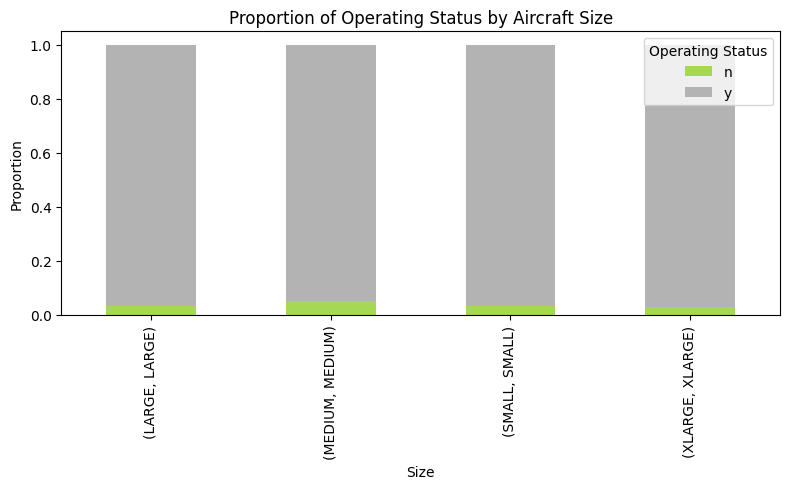

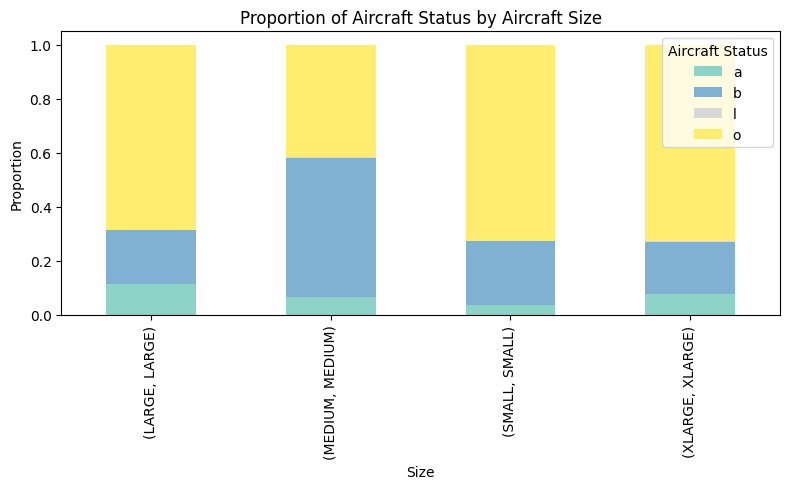

In [75]:
# create new colume size by quartiles
quartiles = cleaned_aircraft_inventory['NUMBER_OF_SEATS'].quantile([0.25, 0.5, 0.75])
q1, q2, q3 = quartiles[0.25], quartiles[0.5], quartiles[0.75]

def categorize_size(seats):
    if seats < q1:
        return "SMALL"
    elif seats < q2:
        return "MEDIUM"
    elif seats < q3:
        return "LARGE"
    else:
        return "XLARGE"

cleaned_aircraft_inventory['SIZE'] = cleaned_aircraft_inventory['NUMBER_OF_SEATS'].apply(categorize_size)

# OPERATING_STATUS
operating_status_prop = (
    cleaned_aircraft_inventory
    .groupby(['SIZE', 'OPERATING_STATUS_STD'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)

# Plot
operating_status_prop.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set2')
plt.title('Proportion of Operating Status by Aircraft Size')
plt.ylabel('Proportion')
plt.xlabel('Size')
plt.legend(title='Operating Status')
plt.tight_layout()
plt.show()

# AIRCRAFT_STATUS
aircraft_status_prop = (
    cleaned_aircraft_inventory
    .groupby(['SIZE', 'AIRCRAFT_STATUS_STD'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)

# Plot
aircraft_status_prop.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set3')
plt.title('Proportion of Aircraft Status by Aircraft Size')
plt.ylabel('Proportion')
plt.xlabel('Size')
plt.legend(title='Aircraft Status')
plt.tight_layout()
plt.show()


Aircraft Size Distribution: Aircraft were categorized into SMALL, MEDIUM, LARGE, and XLARGE based on NUMBER_OF_SEATS quartiles.

Operating Status Trends:

SMALL aircraft had the lowest proportion of operating units — many are not currently in service.

As size increases, the likelihood of being in operation rises, with XLARGE aircraft being most likely to be actively operating.

Aircraft Status Trends:

SMALL aircraft had a higher proportion of inactive or retired classifications.

LARGE and XLARGE aircraft were far more likely to be listed as active, suggesting they’re part of major commercial fleets.

Implication: Larger aircraft are more operationally relevant and better maintained, while smaller planes may be older, less efficient, or no longer economically viable.

